In [1]:
# to use cd, etc
import sys
import os

import numpy as np
# for math work
from numpy import linalg, matlib
# save, import and load data
from numpy import asarray, save, load

# needed for some matrix manipulations
import cvxpy as cp
# import math 

import scipy
# for curve fitting
from scipy import optimize
from scipy.io import loadmat  # this is the SciPy module that loads mat-files

from sklearn.metrics import r2_score, mean_squared_error

import mat73
import pandas as pd

import matplotlib.pyplot as plt
# for plots
import seaborn
# set up seaborn for the plots
seaborn.set()

# suppress deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# # to save data plots
from matplotlib.backends.backend_pdf import PdfPages

import pickle

In [2]:
path = '/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/'
file = '2021Jul19data.pkl'

with open(path + file , 'rb') as infile:
    y_, ypred, K_, targs, ylast = pickle.load(infile)

In [3]:
def sg(c,u,N,D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )

  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.randn(N,u.size)
  #d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D
  d.reshape(tuple([N]+list(u.shape)))
  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    Dc[n] = (c(u+d[n]) - c(u-d[n])) * d[n] 
  Dc /= 2*D**2
  return Dc

def gd(c,u0,Dc,g,I):
  """
  gradient descent
  for i in I:
    u -= g(u)*Dc(u)

  inputs:
    c : U -> R
    u0 in U - decision variable in vector space U
    g(u,i) > 0 - step size
    I - int - number of iterations

  outputs:
    U in I x U
  """
  U = np.nan*np.zeros((I,u0.size))
  U.reshape(tuple([I]+list(u0.shape)))
  U[0] = u0
  for i in range(I-1):
    U[i+1] = U[i] - g(U[i],i) * Dc(U[i])
  return U

def PSD(n,sqrt=False):
  """
  compute random positive semidefinite matrix

  input:
    n - int - dimension of matrix
    (optional)
    sqrt - bool - whether to return S such that Q = np.dot( S.T, S)

  output:
    Q - n x n - Q = Q^T,  spec Q \subset [0,oo)
  """
  H = np.random.randn( n, n )
  d,u = np.linalg.eig( H + H.T )
  d *= np.sqrt(np.arange(d.size)+.1)
  S = np.dot( u, np.dot( np.diag( np.sqrt( d*np.sign( d ) ) ), u.T ) )
  Q = np.dot( S.T, S )
  if sqrt:
    return Q, S
  else:
    return Q

In [34]:
N = 100
D = 1e-1
lamba_k = .001

# u is each K
c = lambda e, u : np.linalg.norm(e, 2)**2 + lamba_k*np.linalg.norm(u, 2)**2 

In [53]:
Dc = lambda u : sg(c,u,N,D).mean(axis=0)
g = lambda u,i : 1e-1#/(i+1)
I = 20

U_ = []
cU_ = []

g_g = lambda u,i : .5
ck_ = lambda u: ck(ylast[0]-targs[0], u)
Dck = lambda u: sg(ck_,u,N,D).mean() # derivative

Knext = []
mse = []

for ii in range(5000, 5500, 1):
    Ksolve = gd(ck_,np.ndarray.flatten(K_[:,:, ii]),Dck,g_g, 2)[-1] # -1 becuase it comes out as a [2, xx] array and you need the last step
#     print(np.array(Ksolve).shape)
    Knext.append(Ksolve)   
    mse.append(mean_squared_error(Ksolve, np.ndarray.flatten(K_[:, :, ii+1])))
#     print(mse[-1])

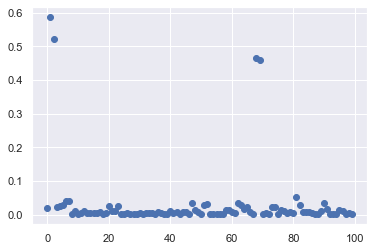

In [47]:
plt.scatter(range(100), mse)
plt.show()

In [48]:
np.array(Knext).shape

(100, 76)

In [50]:
np.mean(Knext)

0.0019500047588805688

In [49]:
slope, intercept, r, p, se = scipy.stats.linregress(np.ndarray.flatten(K_[:,:, 1:101]), np.ndarray.flatten(np.array(Knext)))
print(slope, intercept, r, p, se)
# def plot_r2(xdata, ydata,label):
#     plt.scatter(xdata, ydata)
#     slope, intercept, r, p, se = scipy.stats.linregress(np.ndarray.flatten(xdata), np.ndarray.flatten(ydata))
    
#     plt.plot(np.linspace(min(np.sort(np.ndarray.flatten(xdata))),max(np.sort(np.ndarray.flatten(xdata))),10),np.linspace(min(np.sort(np.ndarray.flatten(xdata))),max(np.sort(np.ndarray.flatten(xdata))),10)*slope+ intercept,'r')
#     plt.xlabel("cursor " + str(label))
#     plt.ylabel("prediction: cursor " + str(label))
#     plt.title("pred of "+ str(label) + "| r-squared = " + str(r))
#     plt.show()

# plot_r2(y_[0], ypred[0], "x pos")
# plot_r2(y_[1], ypred[1], "y pos")
# plot_r2(y_[2], ypred[2], "x vel")
# plot_r2(y_[3], ypred[3], "y vel")

0.002356307471087511 0.0019446802732504668 0.0023484082232278175 0.8378095758198467 0.011510853473438868


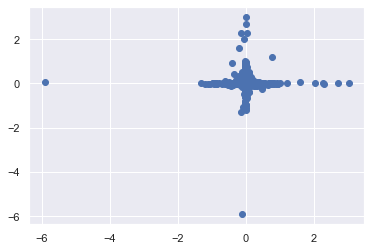

In [51]:
plt.scatter(np.ndarray.flatten(K_[:,:, 1:101]), np.ndarray.flatten(np.array(Knext)))